# DPU example: MNIST Classifier
----

## Aim/s

This notebook shows how to deploy Convolutional Neural Network (CNN)
model for hand-written digit recognition. The network was trained on
the MNIST dataset,quantized using Vitis AI compiler tools, and
deployed on the DPU.

Compared to the other notebooks delivered in this folder, this notebook
shows how to deploy a **user-trained** DPU model on PYNQ image; i.e.,
the model used in this notebook does not come from the model zoo.

## References

* [Train your own DPU models](https://github.com/Xilinx/DPU-PYNQ/tree/master/host#train-your-own-dpu-models-from-scratch)
* [Vitis AI model zoo](https://github.com/Xilinx/Vitis-AI/tree/master/models/AI-Model-Zoo)

## Last revised
* Mar 8, 2021
    * Initial revision
----

## 1. Prepare the overlay
We will download the overlay onto the board. 

In [4]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

The `load_model()` method will automatically prepare the `graph`
which is used by VART.

In [5]:
overlay.load_model("mnist.xmodel")

Let's import some libraries as well. The `mnist` package
requires some additional headers for URL requests.

In [6]:
from time import time
import numpy as np
import mnist
import matplotlib.pyplot as plt
%matplotlib inline
from six.moves import urllib

opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

## 2. Load test data

The `mnist` package enables the following data for users:

* `test_images()`: returns test images stored as a numpy array. 
Each image is a grayscale 28x28 pixels, representing a digit between 0 and 9.
* `test_labels()`: returns a list of the true labels stored as numpy array.


There are 2 pre-processing steps we need to do to the test images 
before we can use it:

1. The raw numpy array delivered by `mnist` has a data type of 
uint8 (data ranges from 0 to 255); we need to normalize the elements to 
floating-point numbers ranging from 0 to 1.
2. The VART API will expect each input sample to have 3 dimensions; 
so we need to expand the original numpy array.

In [7]:
raw_data = mnist.test_images()
normalized_data = np.asarray(raw_data/255, dtype=np.float32)
test_data = normalized_data.reshape(10000,4,14,14)
print(np.shape(normalized_data))
# test_data = np.expand_dims(normalized_data, axis=3)
print(np.shape(test_data))
test_label = mnist.test_labels()

print("Total number of test images: {}".format(test_data.shape[0]))
print("  Dimension of each picture: {}x{}".format(test_data.shape[1],
                                                  test_data.shape[2]))

(10000, 28, 28)
(10000, 4, 14, 14)
Total number of test images: 10000
  Dimension of each picture: 4x14


## 3. Use VART
Now we should be able to use VART API to do the task.

In [8]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

softmax = np.empty(outputSize)

We can define a few buffers to store input and output data.
They will be reused during multiple runs.

In [9]:
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
image = input_data[0]

We will also define a few functions to calculate softmax.

In [10]:
def calculate_softmax(data):
    result = np.exp(data)
    return result

## 4. Run DPU to make predictions

We can now classify a couple of digit pictures. For each picture, 
the classification result (shown as 'Prediction') is displayed on top of 
the picture. 

ValueError: cannot reshape array of size 560 into shape (28,28)

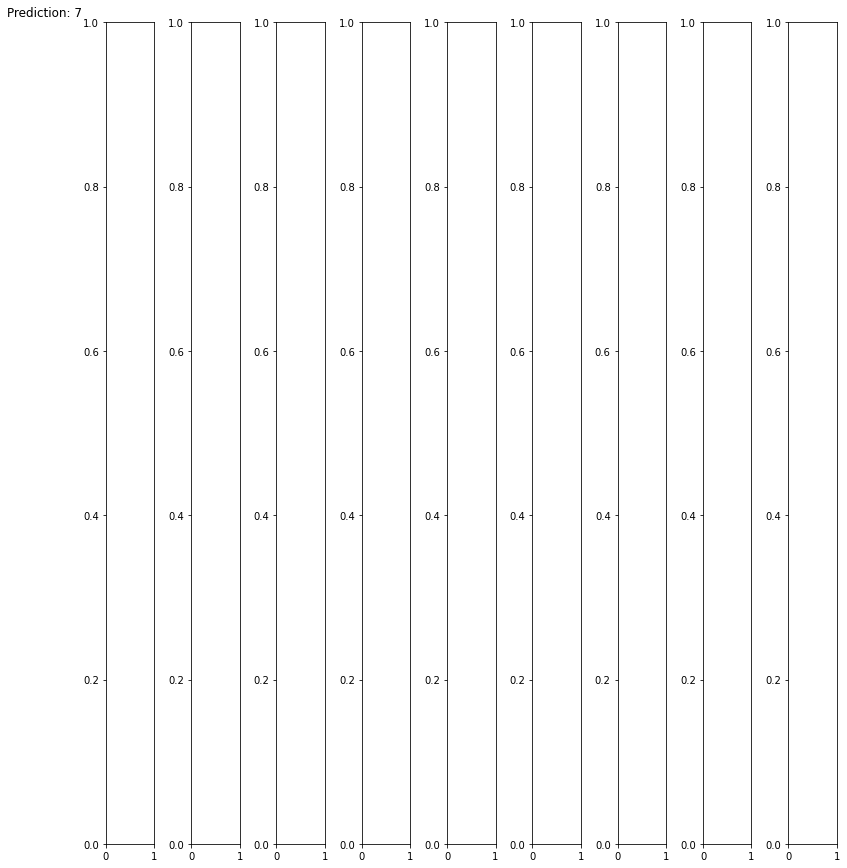

In [14]:
num_pics  = 10
fix, ax = plt.subplots(1, num_pics, figsize=(12,12))
plt.tight_layout()
for i in range(num_pics):
    image[0,...] = test_data[i]
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = calculate_softmax(temp[0][0])
    prediction = softmax.argmax()

    ax[i].set_title('Prediction: {}'.format(prediction))
    ax[i].axis('off')
    print(np.shape(test_data[i]))
    ax[i].imshow(test_data[i,:,:,4:].reshape(28,28), 'gray')

We can also evaluate on the entire test dataset.

In [17]:
total = test_data.shape[0]
predictions = np.empty_like(test_label)
print("Classifying {} digit pictures ...".format(total))

start = time()
for i in range(total):
    image[0,...] = test_data[i]
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = calculate_softmax(temp[0][0])
    predictions[i] = softmax.argmax()

stop = time()
correct = np.sum(predictions==test_label)
execution_time = stop-start
print("Overall accuracy: {}".format(correct/total))
print("  Execution time: {:.4f}s".format(execution_time))
print("      Throughput: {:.4f}FPS".format(total/execution_time))

Classifying 10000 digit pictures ...
Overall accuracy: 0.9752
  Execution time: 2.5187s
      Throughput: 3970.3346FPS


## 5. Clean up

We will need to remove references to `vart.Runner` and let Python garbage-collect
the unused graph objects. This will make sure we can run other notebooks without
any issue.

In [18]:
del overlay
del dpu

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----